# here we go

In [14]:
# region imports and pre-definitions

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm import tqdm

from shapely.plotting import plot_polygon
from shapely.affinity import rotate
from shapely.geometry import Polygon

from geometry import to_polygons
from geometry import annular_wedge_polygon

from geometry import regular_polygon
from geometry import circle
from geometry import rectangle
from geometry import square

from geometry import oblique_lattice
from geometry import regular_lattice

from geometry import platonic_tiles

from geometry import gaussian_ring
from geometry import radial_lobe

# endregion

In [31]:
# shape generator: radial lobed shape
# shape1 = make_radial_lobe(n=6, r_base=10, amplitude=10)
# shape2 = make_gaussian_ring(n=6)
# shape1 = make_gaussian_ring(n=6, r0=0, amplitude=10, sigma=2, width=5)
# shape2 = make_gaussian_ring(n=6, r0=0, amplitude=10, sigma=2, width=5)
w = 0.1
a = 1
shape1 = platonic_tiles(a=a, n=6, w=w)
shape2 = platonic_tiles(a=a, n=6, w=w, theta=45)
# shape2 = make_regular_polygon(n=3)

theta_lim = (0, 30)
r_lim = (0, 10)

wedge = annular_wedge_polygon(*r_lim, *theta_lim)
circle0 = circle(r=10)
aperture1 = to_polygons(circle0.difference(shape1))
aperture2 = to_polygons(circle0.difference(shape2))

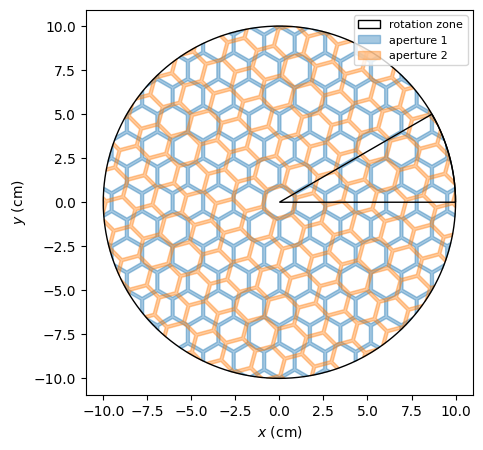

In [32]:
# region show shapes and difference
%matplotlib inline
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5, 5),
)
plot_polygon(circle0, ax=ax, add_points=False, color="black", fill=False, zorder=2)
plot_polygon(
    wedge,
    ax=ax,
    add_points=False,
    edgecolor='k',
    fill=False,
    alpha=1,
    label="rotation zone",
    zorder=2
)
for j, poly in enumerate(aperture1):
    plot_polygon(
        poly,
        ax=ax,
        add_points=False,
        fill=True, color="C0", alpha=0.4,
        label=f"aperture 1" if j == 0 else None,
    )
for j, poly in enumerate(aperture2):
    plot_polygon(
        poly,
        ax=ax,
        add_points=False,
        fill=True,color="C1", alpha=0.4,
        label=f"aperture 2" if j == 0 else None,
    )

ax.axis("equal")
ax.set_xlabel("$x$ (cm)")
ax.set_ylabel("$y$ (cm)")
ax.legend(loc="upper right", fontsize=8)
# endregion 

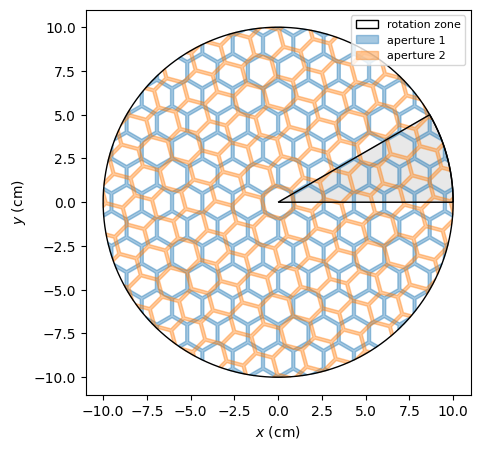

In [33]:
# make animation of rotating shape2

fig, ax = plt.subplots(figsize=(5, 5))

plot_polygon(circle0, ax=ax, add_points=False, color="black", fill=False, zorder=2)
plot_polygon(
    wedge,
    ax=ax,
    add_points=False,
    fill=True,
    facecolor="lightgrey",
    edgecolor="grey",
    alpha=0.5,
)

patch_wedge = plot_polygon(
    annular_wedge_polygon(
        r_inner=r_lim[0],
        r_outer=r_lim[1],
        start_angle_deg=theta_lim[0],
        end_angle_deg=theta_lim[0],
    ),
    ax=ax,
    add_points=False,
    edgecolor="k",
    fill=False,
    alpha=1,
    label="rotation zone",
    zorder=10,
)

for j, poly in enumerate(aperture1):
    plot_polygon(
        poly,
        ax=ax,
        add_points=False,
        color="C0",
        alpha=0.4,
        label="aperture 1" if j == 0 else None,
    )

patches2 = []
for j, poly in enumerate(aperture2):
    patches2.append(
        plot_polygon(
            poly,
            ax=ax,
            add_points=False,
            color="C1",
            alpha=0.4,
            label=f"aperture 2" if j == 0 else None,
        )
    )
patches2.append(patch_wedge)

ax.set_aspect("equal")
ax.set_xlabel("$x$ (cm)")
ax.set_ylabel("$y$ (cm)")
ax.legend(loc="upper right", fontsize=8)


# --- animation update function ---
def update(frame_angle: int):
    for i, poly in enumerate(aperture2):
        patches2[i].remove()
        poly = rotate(poly, frame_angle, origin=(0, 0))
        patches2[i] = plot_polygon(poly, ax=ax, add_points=False, color="C1", alpha=0.4)

    patches2[-1].remove()
    patches2[-1] = plot_polygon(
        annular_wedge_polygon(
            r_inner=r_lim[0],
            r_outer=r_lim[1],
            start_angle_deg=theta_lim[0],
            end_angle_deg=frame_angle,
        ),
        ax=ax,
        edgecolor="k",
        add_points=False,
        fill=False,
        zorder=10,
    )
    return patches2


# --- create and display animation ---
angles = np.linspace(theta_lim[0], theta_lim[1], 90)  # 60 frames from 0 to 90 degrees
anim = FuncAnimation(fig, update, frames=angles, blit=True, interval=15, repeat=True)
anim.save("geometric_animation.mp4", writer="ffmpeg", dpi=200)

In [ ]:
# --- Analysis ---

radii = np.linspace(r_lim[0], r_lim[1], 101, dtype=np.float64)  # cm
degrees = np.linspace(theta_lim[0], theta_lim[1], 61, dtype=np.float64)  # deg
radians = np.deg2rad(degrees)  # rad

dr = (np.max(radii) - np.min(radii)) / (len(radii) - 1)
ddeg = (np.max(degrees) - np.min(degrees)) / (len(degrees) - 1)
drad = (np.max(radians) - np.min(radians)) / (len(radians) - 1)

ext_deg = (
    degrees[0] - ddeg / 2,
    degrees[-1] + ddeg / 2,
    radii[0] - dr / 2,
    radii[-1] + dr / 2,
)
ext_rad = (
    radians[0] - drad / 2,
    radians[-1] + drad / 2,
    radii[0] - dr / 2,
    radii[-1] + dr / 2,
)

rings: list[Polygon] = []
ring_area: list[float] = []

for j, r in enumerate(radii):
    circle1 = circle(r=max(r - dr / 2, r_lim[0]), n_points=360)
    circle2 = circle(r=min(r + dr / 2, r_lim[1]), n_points=360)
    ring = to_polygons(circle2.difference(circle1))[0]
    rings.append(ring)
    ring_area.append(ring.area)

A_rel = np.zeros((len(radii), len(degrees)), dtype=np.float64)  # cm^2
for i, angle_deg in enumerate(tqdm(degrees)):
    tmp_shape2 = rotate(shape2, angle_deg)
    tmp_shape0 = shape1.buffer(0).intersection(tmp_shape2.buffer(0))

    for j, r in enumerate(radii):
        if ring_area[j] != 0.0:
            tmp_slice = tmp_shape0.intersection(rings[j])
            A_rel[j, i] = tmp_slice.area / ring_area[j]

A_theta = np.sum(A_r, axis=0)  # cm^2
A_theta_avg = np.mean(A_r, axis=0)  # cm^2
A_rel = A_theta  # / (r_lim[1] ** 2 * np.pi) * 1e2  # %

r_com = np.sum(radii[:, np.newaxis] * A_r, axis=0) / A_theta  # cm
N_r = A_r / A_theta_avg[np.newaxis, :]

100%|██████████| 61/61 [00:10<00:00,  5.71it/s]


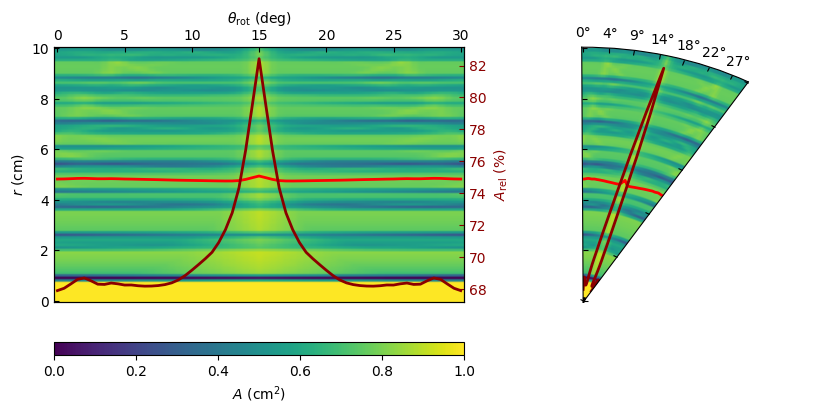

In [38]:
# show analysis results

fig = plt.figure(0, figsize=(10, 4))
gs = fig.add_gridspec(
    2, 2, width_ratios=[5, 4], hspace=0.3, wspace=0.1, height_ratios=[4, 0.2]
)

ax_kar = fig.add_subplot(gs[0, 0])
ax_rad = fig.add_subplot(gs[0, 1], projection="polar")
ax_clb = fig.add_subplot(gs[1, 0])
ax_kar2 = ax_kar.twinx()

cmap = "viridis"

color_com = "red"
color_area = "darkred"  # colors(3)

# cmap = cpd.cmap(color="seeblau", inverse=True)
# color_com = cpd.colors(2)

im = ax_kar.imshow(
    A_r,
    extent=ext_deg,
    origin="lower",
    aspect="auto",
    cmap=cmap,
)
im = ax_rad.imshow(
    A_r,
    extent=ext_rad,
    origin="lower",
    aspect="auto",
    cmap=cmap,
)
clb = fig.colorbar(im, cax=ax_clb, orientation="horizontal")
ax_kar.plot(degrees, r_com, lw=2, color=color_com)
ax_kar2.plot(degrees, A_rel, lw=2, color=color_area)

ax_rad.plot(radians, r_com, lw=2, color=color_com)

n0, n1 = ax_kar2.get_ylim()

ax_rad.plot(radians, (A_rel - n0) / (n1 - n0) * r_lim[1], lw=2, color=color_area)

ax_kar.set_xlabel("$\\theta_\\mathrm{rot}$ (deg)")
ax_kar.set_ylabel("$r$ (cm)")
ax_kar2.set_ylabel("$A_\\mathrm{rel}$ (%)", color=color_area)
clb.set_label("$A$ (cm$^2$)")

ax_kar.tick_params(direction="in", left=True, right=False, top=True, bottom=True)
ax_rad.tick_params(direction="in", left=True, right=True, top=True, bottom=True)
ax_kar2.tick_params(
    direction="in",
    left=False,
    right=True,
    top=True,
    bottom=True,
    color=color_area,
    labelcolor=color_area,
)
ax_kar.xaxis.set_ticks_position("top")
ax_kar.xaxis.set_label_position("top")

ax_rad.set_xlim((ext_rad[0], ext_rad[1]))
ax_rad.set_theta_zero_location("N")
ax_rad.set_theta_direction(-1)
ax_rad.set_yticklabels([])
ax_rad.grid(False)

In [36]:
# # show analysis results

# fig = plt.figure(0, figsize=(10, 8))
# gs = fig.add_gridspec(
#     2, 3, height_ratios=[4, 4], width_ratios=[5, 4, 0.2], hspace=0.3, wspace=0.1
# )

# ax1_kar = fig.add_subplot(gs[0, 0])
# ax1_rad = fig.add_subplot(gs[0, 1], projection="polar")
# ax1_clb = fig.add_subplot(gs[0, 2])

# ax2_kar = fig.add_subplot(gs[1, 0])
# ax2_rad = fig.add_subplot(gs[1, 1], projection="polar")
# ax2_clb = fig.add_subplot(gs[1, 2])

# cmap1 = "viridis"  # cmap(color="seeblau", inverse=True)
# cmap2 = "viridis"  # cmap(color="seegrün", inverse=True)

# color_com = "red"  # colors(2)
# color_area = "darkred"  # colors(3)

# im1 = ax1_kar.imshow(
#     A_r,
#     extent=ext_deg,
#     origin="lower",
#     aspect="auto",
#     cmap=cmap1,
# )
# im1 = ax1_rad.imshow(
#     A_r,
#     extent=ext_rad,
#     origin="lower",
#     aspect="auto",
#     cmap=cmap1,
# )
# clb1 = fig.colorbar(im1, cax=ax1_clb)

# im2 = ax2_kar.imshow(
#     N_r,
#     extent=ext_deg,
#     origin="lower",
#     aspect="auto",
#     cmap=cmap2,
# )
# im2 = ax2_rad.imshow(
#     N_r,
#     extent=ext_rad,
#     origin="lower",
#     aspect="auto",
#     cmap=cmap2,
# )
# clb2 = fig.colorbar(im2, cax=ax2_clb)

# for ax in [ax1_kar, ax1_rad, ax2_kar, ax2_rad]:
#     ax.tick_params(direction="in", left=True, right=True, top=True, bottom=True)

# for ax in [ax1_rad, ax2_rad]:
#     ax.plot(radians, r_com, lw=2, color=color_com)
#     ax.set_xlim((ext_rad[0], ext_rad[1]))
#     ax.set_theta_zero_location("N")
#     ax.set_theta_direction(-1)
#     ax.grid(False)
#     ax.set_yticklabels([])

# for ax in [ax1_kar, ax2_kar]:
#     ax.plot(degrees, r_com, lw=2, color=color_com)
#     ax.set_xlabel("$\\theta_\\mathrm{rot}$ (deg)")
#     ax.set_ylabel("$r$ (cm)")
#     ax.xaxis.set_ticks_position("top")
#     ax.xaxis.set_label_position("top")
#     ax2 = ax.twinx()
#     ax2.plot(degrees, A_rel, lw=2, color=color_area)
#     ax2.tick_params(
#         direction="in",
#         left=False,
#         right=True,
#         top=True,
#         bottom=True,
#         color=color_area,
#         labelcolor=color_area,
#     )
#     ax2.set_ylabel("$A_\\mathrm{rel}$ (%)", color=color_area)

# clb1.set_label("$A$ (cm$^2$)")
# clb2.set_label("$A(r, \\theta) / \\langle A\\rangle_r(\\theta)$ (arb.u.)")